# Shakespearean Natural Language Generation (NLG)

---

__Elliott Forney__

__This notebook is a work in progress...__

Language models work by attempting to continually predict the next word in a large corpus of text.

Say that we have a vocabulary, $\mathbf{V}$, that contains $N$ words and that we also have a phrase consisting of $M$ words, $w_1, w_2, ..., w_M,$ where each word is in $\mathbf{V}$.  Then, for each timestep, $t$, in our phrase, our model will attempt to predict

$$
  P(w_t = v_i\; | \; w_{t-1}, \; w_{t-2}, \; ..., \; w_1)
$$

for each word $v_i$ in $\mathbf{V}$.  In other words, we are continually predicting the probability that each word in our vocabulary will occur next, given a previous sequence of actual observed words.

Language models have many uses.  This includes applications in transfer learning for solving various types of NLP problems, such as classification, named entity recognition and sentiment analysis.  Language models can also be used to generate artificial text in a process called Natural Language Generation (NLG).  NLG has various applications, including text generation for deceiving search engines, generating script to be presented by chat bots and creating responses for question answering systems.

In this example, we will create a very simple NLG system that mimics Shakespearean text using a relatively simple Elman Recurrent Neural Network (RNN).

In [1]:
import random, re
import munch

import nltk
import torch as th

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

First, we use NLTK to download the `punkt` data, which is used for word-punctuation tokenization, and the `gutenberg` corpora, which includes a number of freely available texts, including several of Shakespeare's plays: Caesar, Hamlet and Macbeth.

In [2]:
nltk.download('punkt')
nltk.download('gutenberg')
list(enumerate(nltk.corpus.gutenberg.fileids()))

[nltk_data] Downloading package punkt to /home/idfah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/idfah/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


[(0, 'austen-emma.txt'),
 (1, 'austen-persuasion.txt'),
 (2, 'austen-sense.txt'),
 (3, 'bible-kjv.txt'),
 (4, 'blake-poems.txt'),
 (5, 'bryant-stories.txt'),
 (6, 'burgess-busterbrown.txt'),
 (7, 'carroll-alice.txt'),
 (8, 'chesterton-ball.txt'),
 (9, 'chesterton-brown.txt'),
 (10, 'chesterton-thursday.txt'),
 (11, 'edgeworth-parents.txt'),
 (12, 'melville-moby_dick.txt'),
 (13, 'milton-paradise.txt'),
 (14, 'shakespeare-caesar.txt'),
 (15, 'shakespeare-hamlet.txt'),
 (16, 'shakespeare-macbeth.txt'),
 (17, 'whitman-leaves.txt')]

We then, specifically, extract the filenames for the Shakespeare documents.

In [3]:
filenames = nltk.corpus.gutenberg.fileids()[14:17]
filenames

['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']

And then do some data munging to ensure that we have a list of paragraphs for all combined documents and that each paragraph is a list of words represented as python strings.  Note that we use paragraphs rather than sentences in order to ensure our model can capture some level of cross-sentence dependencies.  This will enable our NLG model to produce more than single sentences at a time.  We also remove very short paragraphs, less than three words, and make everything lower case in order to reduce the size of our vocabulary somewhat.  Note that having a binary indicator of capitalization would also be an easy thing to do in order to handle case.

In [4]:
# combine all of the corpora, which are segmented by paragraph, sentences and words
paras_by_sent = sum((list(nltk.corpus.gutenberg.paras(filename)) for filename in filenames), [])

# combine sentences so each element in paras is a list of words in each paragraph
paras = [sum((sent for sent in para), []) for para in paras_by_sent]

# filter out very short paragraphs
paras = list(filter(lambda para: len(para) > 3, paras))

# make everything lower case
paras = [[word.lower() for word in para] for para in paras]

# print a few paragraphs
for i, para in enumerate(paras[:7]):
    print(i, para)

0 ['[', 'the', 'tragedie', 'of', 'julius', 'caesar', 'by', 'william', 'shakespeare', '1599', ']']
1 ['actus', 'primus', '.', 'scoena', 'prima', '.']
2 ['enter', 'flauius', ',', 'murellus', ',', 'and', 'certaine', 'commoners', 'ouer', 'the', 'stage', '.']
3 ['flauius', '.', 'hence', ':', 'home', 'you', 'idle', 'creatures', ',', 'get', 'you', 'home', ':', 'is', 'this', 'a', 'holiday', '?', 'what', ',', 'know', 'you', 'not', '(', 'being', 'mechanicall', ')', 'you', 'ought', 'not', 'walke', 'vpon', 'a', 'labouring', 'day', ',', 'without', 'the', 'signe', 'of', 'your', 'profession', '?', 'speake', ',', 'what', 'trade', 'art', 'thou', '?', 'car', '.', 'why', 'sir', ',', 'a', 'carpenter']
4 ['mur', '.', 'where', 'is', 'thy', 'leather', 'apron', ',', 'and', 'thy', 'rule', '?', 'what', 'dost', 'thou', 'with', 'thy', 'best', 'apparrell', 'on', '?', 'you', 'sir', ',', 'what', 'trade', 'are', 'you', '?', 'cobl', '.', 'truely', 'sir', ',', 'in', 'respect', 'of', 'a', 'fine', 'workman', ',', 'i', 'a

It also turns out that not all paragraphs end with proper punctuation, since they are plays, so we add a period to any sentence that ends with a word.  We also add a special `<end>` word to the end of each paragraph so that the network will have a way to denote that a paragraph has terminated and a new one is beginning.

Finally, we sort the paragraphs by length.  This ensures that paragraphs with similar length will be grouped together when generating minibatches for training, which, in turn, reduces padding and reduces the computational cost during training.

In [5]:
# add a period to the end of paragraphs that end without punctuation
word_regex = re.compile(r'\w')
def fix_end_punct(para):
    if word_regex.match(para[-1]):
        return para + ['.']
    return para

paras = list(map(fix_end_punct, paras))

# add a newline at the end of each paragraph
paras = [para + ['<end>',] for para in paras]

# sort by length, reduces padding and speeds up training
paras = sorted(paras, key=len)

# print the first few paragraphs
for i, para in enumerate(paras[:7]):
    print(i, para)

0 ['shout', '.', 'flourish', '.', '<end>']
1 ['they', 'stab', 'caesar', '.', '<end>']
2 ['low', 'march', 'within', '.', '<end>']
3 ['exeunt', '.', 'omnes', '.', '<end>']
4 ['exit', 'the', 'ghost', '.', '<end>']
5 ['laer', '.', 'farewell', '.', '<end>']
6 ['ghost', 'beckens', 'hamlet', '.', '<end>']


Next, let's print some quick summary statistics.  We have about 2,160 paragraphs with a total of 19,669 words.  A histogram of the paragraph lengths also shows that the vast majority of paragraphs are quite short.

nparas: 2160
nwords: 89669


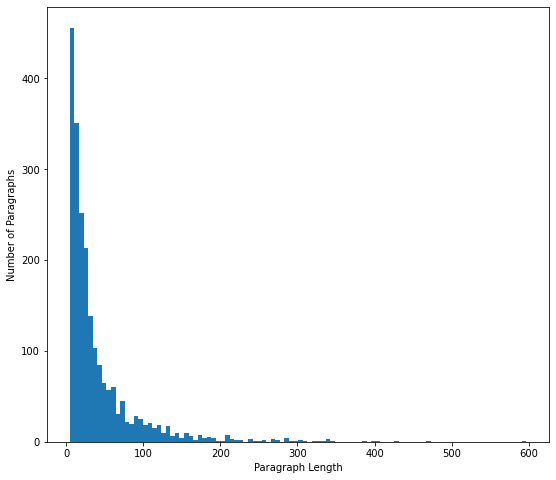

In [6]:
print('nparas:', len(paras))
print('nwords:', sum(len(para) for para in paras))

plt.hist([len(para) for para in paras], bins=100);
plt.xlabel('Paragraph Length');
plt.ylabel('Number of Paragraphs');

We now need to define a class that can represent the vocabulary of words in the corpus and map them to unique integer indices.  These indices will be used to look up the words in a word embedding matrix.  This can be easily achieved by extending the python `dict` class and adding a constructor to generate indices from our list of paragraphs.

We also add `pad` and `unk` special words that represent padding and unknown tokens, respectively.  Padding words will be used to ensure that we are able to generate batches as rectangular tensors and the unknown token is used when a word that is not in the vocabulary is encountered, i.e., during inference.

In [7]:
class IndexVocab(dict):
    '''A map from string words to unique integer indices.
    '''
    # special tokens for padding and out-of-vocab words
    pad, unk, end = '<pad>', '<unk>', '<end>'
    pad_idx, unk_idx, end_idx = tuple(range(3))
    
    def __init__(self, paras):
        '''Initialize a new vocabulary that maps string words to unique
        integer indices.  This can be used to look words up in a word embedding.
        '''
        # create a set of words to make them unique
        words = set(word for para in paras for word in para) \
            .difference((self.pad, self.unk, self.end))
        
        # convert to list and add in special tokens
        words = [self.pad, self.unk, self.end] + sorted(list(words))
        
        # assign indices
        idx_vocab = {word: idx for idx, word in enumerate(words)}
        super().__init__(idx_vocab)
        
        # store the reverse map so we can go back to strings
        self.reverse = {idx: word for word, idx in self.items()}
        
    def get(self, word, default=unk_idx):
        '''Find the integer index for a given string word.
        Returns `unk_idx` if the word is out-of-vocab.
        '''
        return super().get(word, default)

We can then generate a vocabulary over all the paragraphs in our corpus.

In [8]:
vocab = IndexVocab(paras)
list(vocab.items())[:25]

[('<pad>', 0),
 ('<unk>', 1),
 ('<end>', 2),
 ('!', 3),
 ('&', 4),
 ("'", 5),
 ('(', 6),
 (')', 7),
 (',', 8),
 ('-', 9),
 ('.', 10),
 ('1', 11),
 ('1599', 12),
 ('1603', 13),
 ('2', 14),
 ('3', 15),
 ('4', 16),
 (':', 17),
 (':)', 18),
 (';', 19),
 ('?', 20),
 ('[', 21),
 (']', 22),
 ('].', 23),
 ('a', 24)]

In [9]:
all_idxs = [[vocab.get(word) for word in para] for para in paras]
all_idxs[:14]

[[5848, 10, 2530, 10, 2],
 [6606, 6183, 910, 10, 2],
 [3894, 4009, 7406, 10, 2],
 [2269, 10, 4508, 10, 2],
 [2273, 6576, 2763, 10, 2],
 [3653, 10, 2357, 10, 2],
 [2763, 536, 2965, 10, 2],
 [2762, 10, 6440, 10, 2],
 [2269, 10, 2746, 10, 2],
 [24, 4406, 7406, 10, 2],
 [2181, 24, 4116, 10, 2],
 [5227, 6576, 3764, 10, 2],
 [2181, 6868, 1212, 10, 2],
 [4946, 6696, 4802, 10, 2]]

In [10]:
random.shuffle(all_idxs)

nvalid = 150

train_idxs = all_idxs[:-nvalid]
valid_idxs = all_idxs[-nvalid:]

train_idxs.sort(key=len, reverse=True)
valid_idxs.sort(key=len, reverse=True)

train_idxs[-3:]

[[2269, 10, 2746, 10, 2], [2530, 10, 2269, 10, 2], [2181, 6868, 1212, 10, 2]]

In [11]:
class NLGDataset(th.utils.data.Dataset):
    def __init__(self, phrases):
        super().__init__()
        self.phrases = phrases
        
    def __getitem__(self, idx):
        phrase = self.phrases[idx]
        return th.as_tensor(phrase), th.as_tensor(len(phrase))
    
    def __len__(self):
        return len(self.phrases)

In [12]:
train_data = NLGDataset(train_idxs)
valid_data = NLGDataset(valid_idxs)

In [13]:
train_data[-1]

(tensor([2181, 6868, 1212,   10,    2]), tensor(5))

In [14]:
class LanguageModel(th.nn.Module):
    def __init__(self, vocab_size, embed_dim, nhidden):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.nhidden = nhidden
        
        self.embed = th.nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embed_dim,
            padding_idx=IndexVocab.pad_idx)
        
        self.initial_state = th.nn.Parameter(
            th.empty(1, self.nhidden),
            requires_grad=True)
        th.nn.init.xavier_uniform_(self.initial_state)
        
        self.hidden = th.nn.RNN(
            input_size=self.embed_dim,
            hidden_size=self.nhidden)
        
        self.visible = th.nn.Linear(
            in_features=self.nhidden,
            out_features=self.vocab_size)
        
    def forward(self, idxs, lens, state=None):
        assert idxs.ndim == 2
        max_len = idxs.shape[0]
        batch_size = idxs.shape[1]
        
        assert lens.ndim == 1
        assert lens.shape[0] == batch_size
        
        word_vectors = self.embed(idxs)
        
        assert word_vectors.ndim == 3
        assert word_vectors.shape[0] == max_len
        assert word_vectors.shape[1] == batch_size
        assert word_vectors.shape[2] == self.embed_dim
        
        if state is None:
            state = self.initial_state[None, ...].repeat(1, batch_size, 1)
        
        packed_word_vectors = th.nn.utils.rnn.pack_padded_sequence(word_vectors, lens)
        packed_hidden_out, final_state = self.hidden(packed_word_vectors, hx=state)
        hidden_out, _ = th.nn.utils.rnn.pad_packed_sequence(packed_hidden_out)
        
        assert hidden_out.ndim == 3
        assert hidden_out.shape[0] == max_len
        assert hidden_out.shape[1] == batch_size
        assert hidden_out.shape[2] == self.nhidden
        
        visible_out = self.visible(hidden_out)
        assert visible_out.ndim == 3
        assert visible_out.shape[0] == max_len
        assert visible_out.shape[1] == batch_size
        assert visible_out.shape[2] == self.vocab_size
        
        return visible_out, final_state
    
    def labels(self, idxs, lens, state=None):
        preds, final_state = self(idxs, lens, state=state)
        return th.argmax(preds, dim=2), final_state
    
    @th.no_grad()
    def iterate(self, seed_idxs, max_words=64):
        seed_idxs = seed_idxs[:, None]
        
        one_len = th.ones(1, dtype=th.int64)
                
        # initial predictions of seed words
        init_idxs, state = self.labels(
            seed_idxs, th.as_tensor(seed_idxs.shape[0])[None,])
                
        # list of new predictions, start with first seedword
        new_idxs = [seed_idxs,]
        
        # current prediction, starts with last seedword prediction
        idxs = init_idxs[-1][None, :]
        for i in range(max_words):
            idxs, state = self.labels(
                idxs, th.as_tensor(idxs.shape[0])[None,], state=state)
            
            new_idxs.append(idxs)
            
            if idxs[0][0].item() == IndexVocab.end_idx:
                break
                
        return th.cat(new_idxs)

In [15]:
def collate(data):
    phrases, lens = zip(*data)
    return th.nn.utils.rnn.pad_sequence(phrases), th.stack(lens)

In [16]:
train_loader = th.utils.data.DataLoader(train_data, batch_size=3, collate_fn=collate)

In [17]:
def train(model, train_data, valid_data, epochs=30, batch_size=16, learning_rate=0.0015, use_gpu=False):
    if use_gpu:
        model = model.cuda()
    model.train()
    
    result = munch.Munch({
        'train_losses': [],
        'valid_losses': [],
    })
    
    train_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        collate_fn=collate)
    
    valid_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        collate_fn=collate)
    
    loss_func = th.nn.CrossEntropyLoss(reduction='mean')
    
    optimizer = th.optim.Adam(
        filter(lambda param: param.requires_grad, model.parameters()),
        lr=learning_rate)
    
    result.best_valid_loss = float('inf')
    result.best_epoch = 0.0
    best_weights = None
        
    for epoch in range(epochs):
        train_losses = []
        for idxs, lens in train_loader:
            if use_gpu:
                idxs = idxs.cuda()
                lens = lens.cuda()
            
            optimizer.zero_grad()
            
            preds, _final_state = model(idxs[:-1], lens - 1)
            targs = idxs[1:]
            
            loss = loss_func(
                preds.view(-1, preds.shape[-1]),
                targs.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
            
        result.train_losses.append(
            sum(train_losses) / len(train_losses))
        
        valid_losses = []
        for idxs, lens in valid_loader:
            if use_gpu:
                idxs = idxs.cuda()
                lens = lens.cuda()
            
            with th.no_grad():
                preds, _final_state = model(idxs[:-1], lens - 1)
                targs = idxs[1:]
            
                loss = loss_func(
                    preds.view(-1, preds.shape[-1]),
                    targs.view(-1))
            
            valid_losses.append(loss.item())
            
        result.valid_losses.append(
            sum(valid_losses) / len(valid_losses))
        
        if epoch % 32 == 0:
            print(epoch, 'train_loss:', result.train_losses[-1])
            print(epoch, 'valid_loss:', result.valid_losses[-1])

        if result.valid_losses[-1] < result.best_valid_loss:
            #print('best:', epoch)
            result.best_valid_loss = result.valid_losses[-1]
            result.best_epoch = epoch
            
            best_weights = model.state_dict()

    model.load_state_dict(best_weights)        
    
    if use_gpu:
        model = model.cpu()
    model.eval()
    
    return result

In [18]:
model = LanguageModel(
    vocab_size=len(vocab),
    embed_dim=24,
    nhidden=48)

In [19]:
result = train(model, train_data, valid_data, epochs=512, batch_size=48)

0 train_loss: 7.73249702226548
0 valid_loss: 7.053115248680115
32 train_loss: 4.227978978838239
32 valid_loss: 5.468559145927429
64 train_loss: 3.5222068145161582
64 valid_loss: 5.043928921222687
96 train_loss: 3.0616399333590554
96 valid_loss: 4.683694779872894
128 train_loss: 2.7963265549568903
128 valid_loss: 4.414904177188873
160 train_loss: 2.5197512209415436
160 valid_loss: 4.074554622173309
192 train_loss: 2.35137040132568
192 valid_loss: 3.8836010694503784
224 train_loss: 2.234189971571877
224 valid_loss: 3.801573693752289
256 train_loss: 2.1587909772282554
256 valid_loss: 3.811968743801117
288 train_loss: 2.102191862605867
288 valid_loss: 3.859937906265259
320 train_loss: 2.0493033812159585
320 valid_loss: 3.903241515159607
352 train_loss: 2.0152155118329182
352 valid_loss: 3.9966273307800293
384 train_loss: 1.9841538866360982
384 valid_loss: 4.082005620002747
416 train_loss: 1.9628632494381495
416 valid_loss: 4.107345402240753
448 train_loss: 1.9421437240782238
448 valid_loss

In [30]:
seed_words = ['beware', 'the', 'ides',]
seed_idxs = th.as_tensor([vocab.get(word) for word in seed_words])

iter_preds = model.iterate(seed_idxs)
[vocab.reverse[word.item()] for word in iter_preds]

['beware',
 'the',
 'ides',
 'this',
 ',',
 'and',
 'perhaps',
 'plundge',
 'pluckt',
 'collected',
 'bodie',
 'eye',
 'burnes',
 '.',
 'enter',
 'antony',
 '.',
 '<end>']

In [29]:
seed_words = ['she', 'is', 'of']
seed_idxs = th.as_tensor([vocab.get(word) for word in seed_words])

iter_preds = model.iterate(seed_idxs)
[vocab.reverse[word.item()] for word in iter_preds]

['she', 'is', 'of', ',', 'who', "'", 's', 'follow', 'him', '.', '<end>']

In [28]:
seed_words = ['i', 'haue',]
seed_idxs = th.as_tensor([vocab.get(word) for word in seed_words])

iter_preds = model.iterate(seed_idxs)
[vocab.reverse[word.item()] for word in iter_preds]

['i', 'haue', 'it', 'selfe', 'a', 'roman', 'off', '.', '<end>']

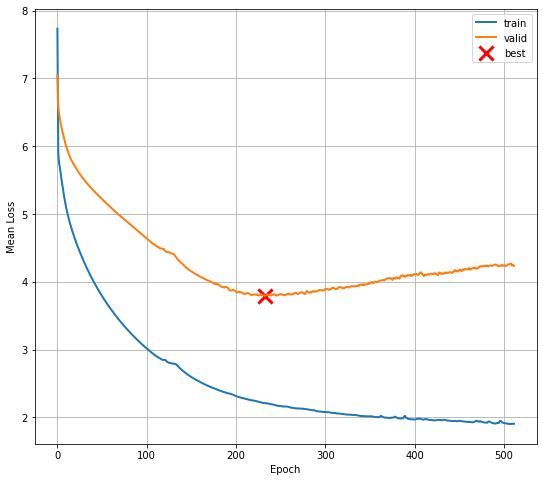

In [22]:
plt.plot(result.train_losses, linewidth=2, label='train');
plt.plot(result.valid_losses, linewidth=2, label='valid');
plt.scatter(
    (result.best_epoch,), (result.valid_losses[result.best_epoch],),
    linewidth=3, s=200, marker='x', color='red', label='best')
plt.legend();
plt.xlabel('Epoch');
plt.ylabel('Mean Loss');
plt.grid();

In [23]:
model.initial_state.detach().squeeze()

tensor([ 0.4414, -1.0238,  0.3816,  0.7942,  0.2409,  0.6877, -0.3190,  0.3703,
        -0.0283, -0.5532,  0.3193,  0.1219, -0.1753,  0.0414,  0.2469,  0.2542,
         0.1744,  0.3157,  0.7874, -0.1048, -0.6390, -0.1800,  0.2171, -0.3694,
         0.7874, -0.0944, -0.3864, -0.6245,  0.2039, -0.5354,  0.5815, -0.5056,
         0.6935,  0.3151,  0.8126, -0.6834, -0.5879, -0.2256, -0.7870,  0.3433,
        -0.3653,  0.2966, -0.2537, -0.2793, -0.2640, -0.5185, -0.4232,  0.0319])

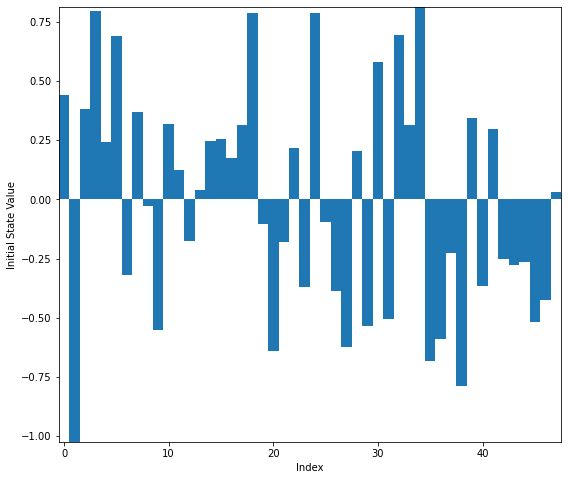

In [24]:
init_state = model.initial_state.detach().squeeze()
plt.bar(range(len(init_state)), init_state, width=1);
plt.xlabel('Index');
plt.ylabel('Initial State Value');
plt.autoscale(tight=True);